* Build BED for intron and upstream region
* intersect with fimo output from the entire genome

In [215]:
import gffutils
from gffutils import pybedtools_integration
import pybedtools
from pybedtools.featurefuncs import gff2bed
import pandas as pd
import seaborn as sb
import statsmodels.api as sm
%matplotlib inline

db = gffutils.FeatureDB('/data/LCDB/lcdb-references/dmel/r6-11/gtf/dmel_r6-11.gtf.db')

In [31]:
idb = gffutils.create_db(db.create_introns(), ":memory:")

In [40]:
for a in idb.featuretypes():
    print(a)

intron


In [78]:
ibed = pybedtools_integration.to_bedtool(idb.features_of_type('intron')).saveas('../../data/dm6_introns.bed')

In [81]:
slopped = ibed.slop(b=1000, s=True, genome='dm6').saveas('../../data/dm6_intron_slop.bed')

In [98]:
#read in fimo output for entire genome (dmmpmm)
#intersect with BED 
fimo = pybedtools.BedTool('../../data/fimo_update/motif_alignments_dmmpmm2009_dm6.gff')
fimo_bed = fimo.each(gff2bed, name_field='Name').saveas()

In [189]:
table = []
with open('../../data/fimo_update/motif_alignments_dmmpmm2009_dm6.gff') as f:
    for line in f: 
        if not line.startswith('##'):
            broken = line.split('\t')
            pattern = broken[8].split(';')[3]
            pval = float(broken[8].split(';')[2][7:])
            qval = float(pattern[7:].strip())
            #TF = broken[8].split(';')[0][5:]
            start = broken[3]
            end = broken[4]
            stuff = (start, end, pval, qval)
            table.append(stuff)
            
new_df= pd.DataFrame(table, columns=['start','end', 'pvalue', 'qvalue'])

In [230]:
new_df.shape

(1214509, 4)

In [192]:
dmm_df = new_df[['start','end','pvalue']]

In [143]:
fimodf = fimo_bed.to_dataframe()
fimodf.head()

,chrom,start,end,name,score,strand
0,chr2L,83873,83881,bcd,48.3,+
1,chr2L,278604,278612,bcd,48.3,+
2,chr2L,383876,383884,bcd,48.3,+
3,chr2L,405797,405805,bcd,48.3,+
4,chr2L,554219,554227,bcd,48.3,+


In [144]:
fimo_bed_df = fimodf.join(dmm_df, how='inner', rsuffix='_r')[['chrom','start','end','name', 'pvalue','strand']]

In [145]:
fimo_bed_df.to_csv('../../data/fimo_update/dmmpmm.bed', sep='\t', header=None, index=False)

In [146]:
fimo_bed_df.head()

,chrom,start,end,name,pvalue,strand
0,chr2L,83873,83881,bcd,0.000015,+
1,chr2L,278604,278612,bcd,0.000015,+
2,chr2L,383876,383884,bcd,0.000015,+
3,chr2L,405797,405805,bcd,0.000015,+
4,chr2L,554219,554227,bcd,0.000015,+


In [147]:
pfimo = pybedtools.BedTool('../../data/fimo_update/dmmpmm.bed')

In [148]:
slopped.head()

chrX	gffutils_derived	intron	19960846	19964954	.	+	.	gene_id "FBgn0031081"; transcript_id "FBtr0070000"; transcript_symbol "Nep3-RA"; gene_symbol "Nep3";
 chrX	gffutils_derived	intron	19963072	19965781	.	+	.	gene_id "FBgn0031081"; transcript_id "FBtr0070000"; transcript_symbol "Nep3-RA"; gene_symbol "Nep3";
 chrX	gffutils_derived	intron	19963945	19966005	.	+	.	gene_id "FBgn0031081"; transcript_id "FBtr0070000"; transcript_symbol "Nep3-RA"; gene_symbol "Nep3";
 chrX	gffutils_derived	intron	19964127	19966196	.	+	.	gene_id "FBgn0031081"; transcript_id "FBtr0070000"; transcript_symbol "Nep3-RA"; gene_symbol "Nep3";
 chrX	gffutils_derived	intron	19964512	19966576	.	+	.	gene_id "FBgn0031081"; transcript_id "FBtr0070000"; transcript_symbol "Nep3-RA"; gene_symbol "Nep3";
 chrX	gffutils_derived	intron	19965072	19967182	.	+	.	gene_id "FBgn0031081"; transcript_id "FBtr0070000"; transcript_symbol "Nep3-RA"; gene_symbol "Nep3";
 chrX	gffutils_derived	intron	19966013	19968080	.	+	.	gene_id "FBgn0031

In [155]:
intersect = pfimo.intersect(slopped, wb=True).saveas()

In [157]:
very_big = intersect.to_dataframe()

/Users/bergeric/miniconda3/lib/python3.5/site-packages/pybedtools/bedtool.py:3287: UserWarning: Default names for filetype bed are:
['chrom', 'start', 'end', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts']
but file has 15 fields; you can supply custom names with the `names` kwarg
  % (self.file_type, _names, self.field_count()))


In [198]:
less_big = very_big[[0,1,2,3,4,5,14]]

In [199]:
less_big.columns = ['chrom','start','end','name','pval','strand','intron_info']

In [200]:
less_big.head()

,chrom,start,end,name,pval,strand,intron_info
0,chr2L,83873,83881,bcd,0.000015,+,"gene_id ""FBgn0002931""; transcript_id ""FBtr0290..."
1,chr2L,83873,83881,bcd,0.000015,+,"gene_id ""FBgn0002931""; transcript_id ""FBtr0330..."
2,chr2L,278604,278612,bcd,0.000015,+,"gene_id ""FBgn0003444""; transcript_id ""FBtr0078..."
3,chr2L,278604,278612,bcd,0.000015,+,"gene_id ""FBgn0003444""; transcript_id ""FBtr0078..."
4,chr2L,278604,278612,bcd,0.000015,+,"gene_id ""FBgn0003444""; transcript_id ""FBtr0078..."


In [201]:
less_big.intron_info[0]

'gene_id "FBgn0002931"; transcript_id "FBtr0290323"; transcript_symbol "net-RB"; gene_symbol "net";'

In [222]:
pvals_c = statsmodels.sandbox.stats.multicomp.multipletests(less_big.pval, alpha=.1, method='fdr_bh')[1]

In [205]:
less_big_copy = less_big.copy()

In [223]:
pvals_c

array([  9.76559899e-05,   9.76559899e-05,   9.76559899e-05, ...,
         9.79615063e-05,   9.76559899e-05,   9.76559899e-05])

In [206]:
less_big_copy['qval'] = list(pvals_c)

In [208]:
less_big_copy.head()

,chrom,start,end,name,pval,strand,intron_info,qval
0,chr2L,83873,83881,bcd,0.000015,+,"gene_id ""FBgn0002931""; transcript_id ""FBtr0290...",0.000098
1,chr2L,83873,83881,bcd,0.000015,+,"gene_id ""FBgn0002931""; transcript_id ""FBtr0330...",0.000098
2,chr2L,278604,278612,bcd,0.000015,+,"gene_id ""FBgn0003444""; transcript_id ""FBtr0078...",0.000098
3,chr2L,278604,278612,bcd,0.000015,+,"gene_id ""FBgn0003444""; transcript_id ""FBtr0078...",0.000098
4,chr2L,278604,278612,bcd,0.000015,+,"gene_id ""FBgn0003444""; transcript_id ""FBtr0078...",0.000098


In [211]:
new_df.head()

,start,end,pvalue,qvalue
0,83874,83881,0.000015,1.0
1,278605,278612,0.000015,1.0
2,383877,383884,0.000015,1.0
3,405798,405805,0.000015,1.0
4,554220,554227,0.000015,1.0


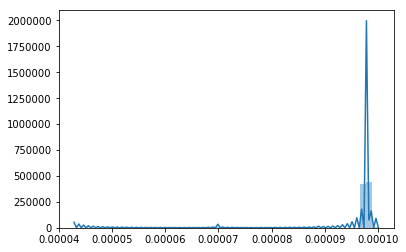

In [224]:
sb.distplot(pvals_c)

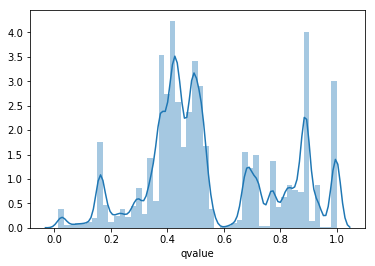

In [217]:
sb.distplot(new_df.qvalue)

In [225]:
import numpy as np

def p_adjust_bh(p):
    """Benjamini-Hochberg p-value correction for multiple hypothesis testing."""
    p = np.asfarray(p)
    by_descend = p.argsort()[::-1]
    by_orig = by_descend.argsort()
    steps = float(len(p)) / np.arange(len(p), 0, -1)
    q = np.minimum(1, np.minimum.accumulate(steps * p[by_descend]))
    return q[by_orig]


In [227]:
pvals_c2 = p_adjust_bh(less_big.pval)

In [228]:
less_big_copy['qval2'] = pvals_c2

In [229]:
less_big_copy

,chrom,start,end,name,pval,strand,intron_info,qval,qval2
0,chr2L,83873,83881,bcd,0.000015,+,"gene_id ""FBgn0002931""; transcript_id ""FBtr0290...",0.000098,0.000098
1,chr2L,83873,83881,bcd,0.000015,+,"gene_id ""FBgn0002931""; transcript_id ""FBtr0330...",0.000098,0.000098
2,chr2L,278604,278612,bcd,0.000015,+,"gene_id ""FBgn0003444""; transcript_id ""FBtr0078...",0.000098,0.000098
3,chr2L,278604,278612,bcd,0.000015,+,"gene_id ""FBgn0003444""; transcript_id ""FBtr0078...",0.000098,0.000098
4,chr2L,278604,278612,bcd,0.000015,+,"gene_id ""FBgn0003444""; transcript_id ""FBtr0078...",0.000098,0.000098
5,chr2L,383876,383884,bcd,0.000015,+,"gene_id ""FBgn0000061""; transcript_id ""FBtr0078...",0.000098,0.000098
6,chr2L,405797,405805,bcd,0.000015,+,"gene_id ""FBgn0003278""; transcript_id ""FBtr0078...",0.000098,0.000098
7,chr2L,554219,554227,bcd,0.000015,+,"gene_id ""FBgn0260933""; transcript_id ""FBtr0078...",0.000098,0.000098
8,chr2L,554219,554227,bcd,0.000015,+,"gene_id ""FBgn0260933""; transcript_id ""FBtr0303...",0.000098,0.000098
9,chr2L,683478,683486,bcd,0.000015,+,"gene_id ""FBgn0000497""; transcript_id ""FBtr0078...",0.000098,0.000098
